In [1]:
# Тюнинг
import optuna as opt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_selection import RFE

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from imblearn.over_sampling import SMOTE

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, SplineTransformer, PowerTransformer, PolynomialFeatures, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessClassifier

%matplotlib inline

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
test_df = pd.read_csv(TEST_DATASET)

# Сбалансированный (ТОЛЬКО ДЛЯ САБМИТА)
# balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
# train_df = balanced_df

# Выравнивание
# first_negatives = train_df[train_df['y'] == 0][:train_df[train_df['y'] == 1]['y'].count()]
# train_df = pd.concat([train_df[train_df['y'] == 1], first_negatives])

# Нормализация всего тренировочного (ТОЛЬКО ДЛЯ САБМИТА)
# train_df = train_df[train_df['Длительность'] < 400]
# train_df = train_df[(train_df['Сумма'] > 2) & (train_df['Сумма'] < 10)]
# train_df = train_df[train_df['До поставки'] < 300]
# train_df = train_df[train_df['Дней между 0_1'] < 400]
# train_df = train_df[train_df['Количество изменений после согласований'] < 2000]
# train_df = train_df[train_df['Количество'] < 300000]

X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Нормализация для кв/тестов
X_train = pd.concat([X_train, y_train], axis=1)

X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [3]:
# Категориальные фичи
# cat_features_чпи = [
#     'Purchasing Organization', 
#     'Company Code', 'Provider', 
#     'Provider Purchaser', 'Operations Manager', 
#     'Material Group', 'Factory',
#     'Purchasing Group', 'EI', 'Weekday'
#     ]

cat_features_lgbm = [
    'Purchasing Organization', 
    'Company Code', 'Provider', 
    'Provider Purchaser', 'Operations Manager', 'Sum Fold',
    'Material Group',
    'Purchasing Group', 'EI', 
    ]

# Фичи на масштабирование
scale_features = [
    'Position Count', 'Duration', 'ETC Delivery',
    'Changes After Approvals', 'Order Approval 1', 'Order Approval 2',
    'Order Approval 3', 'Sum', 'Change Delivery Date 7', 'Change Delivery Date 15', 
    'Change Delivery Date 30', 'Approval Cycles',
    'Handlers 7', 'Handlers 15', 'Handlers 30',
    'Days Between 0_1', 'Days Between 1_2', 'Days Between 2_3', 
    'Days Between 3_4', 'Days Between 4_5',
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8',
    'ETC Difference', 'ETC Power'
]

# Фичи на дроп
drop_features = [
    'Material', 'Cancel Complete Release', 'Month1', 'Month2', 'Month3',
    'Delivery Date', 'Change on Paper', 'Amount',
    'Category Manager', 'NRP', 'Provider Delivery option'
    ]

# Новые имена фич
rename_cols = [
    'Provider', 'Material', 'Category Manager', 'Operations Manager',
    'Factory', 'Purchasing Organization', 'Purchasing Group', 
    'Company Code', 'EI', 'Material Group', 'Delivery Option', 'NRP',
    'Duration', 'ETC Delivery', 'Month1', 'Month2', 'Month3', 'Weekday',
    'Sum', 'Position Count', 'Amount', 'Handlers 7', 'Handlers 15', 
    'Handlers 30', 'Order Approval 1', 'Order Approval 2', 'Order Approval 3',
    'Change Delivery Date 7', 'Change Delivery Date 15', 'Change Delivery Date 30',
    'Cancel Complete Release', 'Change on Paper', 'Delivery Date', 
    'Approval Cycles', 'Changes After Approvals', 'Days Between 0_1', 
    'Days Between 1_2', 'Days Between 2_3', 'Days Between 3_4', 'Days Between 4_5', 
    'Days Between 5_6', 'Days Between 6_7', 'Days Between 7_8'
    ]

In [4]:
# Препроцессоры
class DataPreprocessorCat(BaseEstimator, TransformerMixin):
    """ Предобработчик данных """
    def __init__(self, cat_features, scale_features,
                 drop_features, rename_cols, transform_train=True):
        self.transform_train = transform_train
        self.cat_features = cat_features

        self.robust_scaler = RobustScaler()

        self.rename_cols = rename_cols

        self.drop_features = drop_features
        self.scale_features = scale_features

    def fit(self, X, y=None):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols
        
        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2
        
        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        self.robust_scaler.fit(X_[self.scale_features])

        X_ = X_.drop(self.drop_features, axis=1)
        
        return self
    
    def transform(self, X):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2

        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        X_[self.scale_features] = self.robust_scaler.transform(X_[self.scale_features])

        X_ = X_.drop(self.drop_features, axis=1)

        return X_

In [5]:
# Препроцессоры
class DataPreprocessorLGBM(BaseEstimator, TransformerMixin):
    """ Предобработчик данных """
    def __init__(self, cat_features, scale_features,
                 drop_features, rename_cols, transform_train=True):
        self.transform_train = transform_train
        self.cat_features = cat_features

        self.bin_encoder = BinaryEncoder(cols=cat_features)
        self.robust_scaler = RobustScaler()

        self.rename_cols = rename_cols

        self.drop_features = drop_features
        self.scale_features = scale_features

    def fit(self, X, y=None):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols
        
        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2
        
        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        self.robust_scaler.fit(X_[self.scale_features])
        # Категориальные фичи        
        X_ = self.bin_encoder.fit_transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)
        
        return self
    
    def transform(self, X):
        # Создаём копию датасета
        X_ = X.copy()
        X_.columns = self.rename_cols

        X_['Weekday'] += 1

        # Экстракция фич
        X_['Provider Purchaser'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Purchasing Organization'].values)]
        X_['Provider Delivery option'] = [f'{x}_{y}' for x, y in zip(X_['Provider'].values, X_['Delivery Option'].values)]
        X_['Sum Fold'] = X_['Sum'].apply(lambda x: int(x) % 10)
        X_['ETC Difference'] = X_['Duration'] - X_['ETC Delivery']
        X_['Change Difference'] = X_['Delivery Date'] - X_['Change on Paper']
        X_['ETC Power'] = X_['ETC Difference'] ^ 2

        # Временные фичи
        X_['day_sin'] = np.sin(np.pi * 2 * X_['Weekday'] / 7)
        X_['day_cos'] = np.cos(np.pi * 2 * X_['Weekday'] / 7)
        X_['month1_sin'] = np.sin(np.pi * 2 * X_['Month1'] / 12)
        X_['month1_cos'] = np.cos(np.pi * 2 * X_['Month1'] / 12)
        X_['month2_sin'] = np.sin(np.pi * 2 * X_['Month2'] / 12)
        X_['month2_cos'] = np.cos(np.pi * 2 * X_['Month2'] / 12)
        X_['month3_sin'] = np.sin(np.pi * 2 * X_['Month3'] / 12)
        X_['month3_cos'] = np.cos(np.pi * 2 * X_['Month3'] / 12)

        # Нормализация
        X_[self.scale_features] = self.robust_scaler.transform(X_[self.scale_features])

        # Категориальные фичи
        X_ = self.bin_encoder.transform(X_)

        X_ = X_.drop(self.drop_features, axis=1)

        return X_

In [6]:
# Функция оптимизации
def objective(trial: opt.Trial):
    # Параметры
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    iterations = trial.suggest_int('iterations', 300, 1000)
    max_depth = trial.suggest_int('max_depth', 4, 12)
    reg_lambda = trial.suggest_float('l2_leaf_reg', 0.1, 1)

    # Модель
    data_preprocessor = DataPreprocessorCat(cat_features, scale_features, drop_features, rename_cols)
    model = CatBoostClassifier(
        cat_features=cat_features,
        learning_rate=learning_rate,
        iterations=iterations,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        # auto_class_weights='Balanced'
    )

    pipeline = Pipeline([
        ('data_preproc', data_preprocessor),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
    accuracy = cv_score.mean()

    return accuracy

In [ ]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [17]:
sm = SMOTE(k_neighbors=5)
X_res, y_res = sm.fit_resample(X_train, y_train)
best_params_xgb = {
    'cat_features': cat_features_lgbm,
    'learning_rate': 0.25,
    'iterations': 2000,
    'max_depth': 14,
    'num_leaves': 160,
    'reg_lambda': 0.15,
    'device': 'gpu',
}

In [19]:
data_preprocessor = DataPreprocessorLGBM(cat_features_lgbm, scale_features, drop_features, rename_cols)
model_xgb = XGBClassifier(**best_params_xgb, n_jobs=-1)
pipeline_xgb = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model_xgb)
])

pipeline_xgb.fit(X_res, y_res)
preds_lgbm = pipeline_xgb.predict(X_test)

[19:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "cat_features", "device", "iterations", "num_leaves" } are not used.



In [20]:
print(f1_score(y_test, preds_lgbm, average='macro'))
print(roc_auc_score(y_test, preds_lgbm))

0.8957251486552378
0.8872700698316461


              precision    recall  f1-score   support

           0    0.96645   0.97485   0.97063     18850
           1    0.84310   0.79969   0.82082      3185

    accuracy                        0.94953     22035
   macro avg    0.90477   0.88727   0.89573     22035
weighted avg    0.94862   0.94953   0.94898     22035



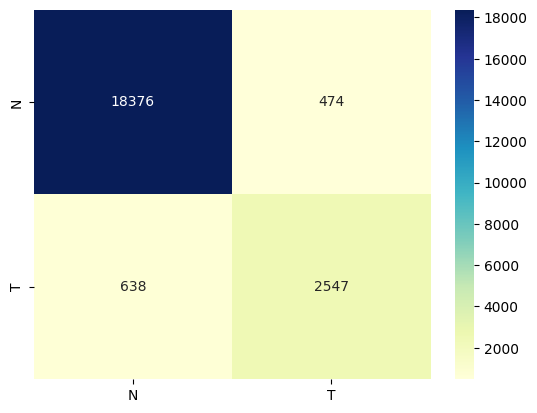

In [21]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds_lgbm) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds_lgbm, digits=5))

In [26]:
sm = SMOTE(k_neighbors=7, random_state=0)
X_res, y_res = sm.fit_resample(X_train, y_train)
best_params_lgbm = {
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Модель
data_preprocessor_lgbm = DataPreprocessorLGBM(cat_features_lgbm, scale_features, drop_features, rename_cols)
model_lgbm = LGBMClassifier(
    **best_params_lgbm,
    n_jobs=-1,
    force_col_wise=True,
    # is_unbalance=True,
    objective='binary'
)

pipeline_lgbm = Pipeline([
    ('data_preproc', data_preprocessor_lgbm),
    ('model', model_lgbm)
])

In [27]:
pipeline_lgbm.fit(X_res, y_res)
preds_lgbm = pipeline_lgbm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 169286, number of negative: 169286
[LightGBM] [Info] Total Bins 3506
[LightGBM] [Info] Number of data points in the train set: 338572, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [28]:
print(f1_score(y_test, preds_lgbm, average='macro'))
print(roc_auc_score(y_test, preds_lgbm))

0.9011654531664084
0.8914973204135765


              precision    recall  f1-score   support

           0    0.96753   0.97703   0.97226     18850
           1    0.85567   0.80597   0.83007      3185

    accuracy                        0.95230     22035
   macro avg    0.91160   0.89150   0.90117     22035
weighted avg    0.95136   0.95230   0.95171     22035



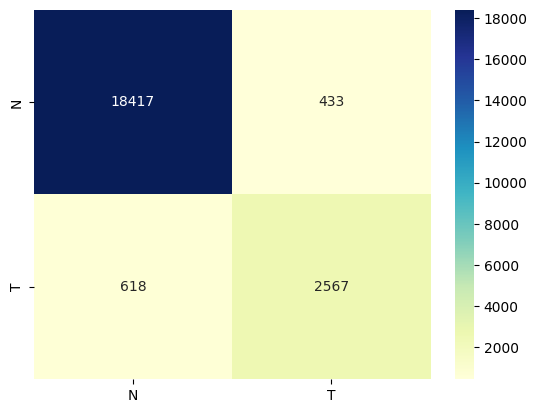

In [29]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds_lgbm) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds_lgbm, digits=5))

In [33]:
preds_lgbm = pipeline_lgbm.predict_proba(X_test)
preds_xgb = pipeline_xgb.predict_proba(X_test)

In [80]:
preds_blend = preds_xgb * 0.35 + preds_lgbm * 0.7
preds = [1 if pred[1] > 0.45 else 0 for pred in preds_blend]
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.9018242323409089
0.8958534076760678


              precision    recall  f1-score   support

           0    0.96920   0.97507   0.97213     18850
           1    0.84696   0.81664   0.83152      3185

    accuracy                        0.95217     22035
   macro avg    0.90808   0.89585   0.90182     22035
weighted avg    0.95153   0.95217   0.95180     22035



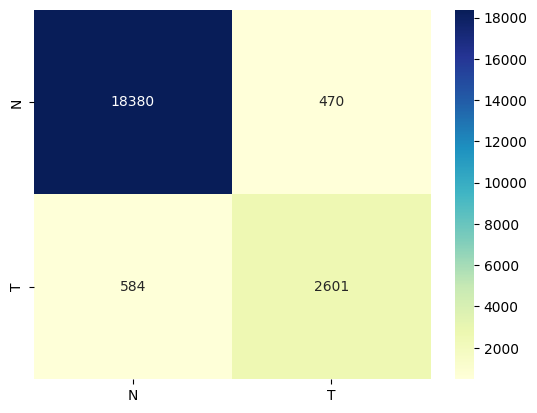

In [79]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           0    0.97271   0.97204   0.97238     18850
           1    0.83521   0.83862   0.83691      3185

    accuracy                        0.95276     22035
   macro avg    0.90396   0.90533   0.90464     22035
weighted avg    0.95284   0.95276   0.95280     22035



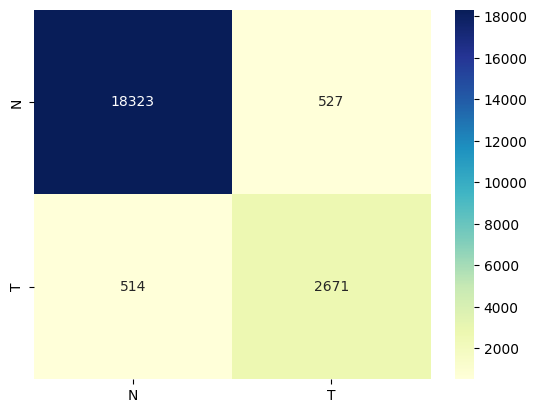

In [36]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, preds) 
import seaborn as sns 
# visualize confusion matrix with seaborn heatmap 
 
cm_matrix = pd.DataFrame(data=cm, columns=['N', 'T'],  
                                 index=['N', 'T']) 
 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
from sklearn.metrics import classification_report 
print(classification_report(y_test, preds, digits=5))

In [ ]:
save_submission(pipeline_xgb, 'submission_cat')

In [ ]:
preds_lgbm = pd.DataFrame(preds)

In [ ]:
%store -r preds_lgbm
preds_lgbm = pd.DataFrame(preds_lgbm)

In [ ]:
res_df = pd.concat([preds_lgbm, preds_lgbm], axis=1)

In [ ]:
res_df

In [ ]:
res_df['equal'] = [1 if x == y else 0 for x, y in zip(res_df.iloc[:, 0].values, res_df.iloc[:, 1].values)]

In [ ]:
res_df['equal'].value_counts()

In [ ]:
preds = pipeline_xgb.predict(X_test)
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))